# Loop 61 Analysis: Final Day Strategy

**CRITICAL: Less than 4 hours remaining, 4 submissions left**

## Objective
1. Verify what's in current submission.csv
2. Analyze the CV-LB relationship to find the best submission strategy
3. Identify any quick wins we might have missed

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load submission history
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},
    {'exp': 'exp_035', 'cv': 0.0098, 'lb': 0.0970},
    {'exp': 'exp_032', 'cv': 0.0082, 'lb': 0.0873},
]

df = pd.DataFrame(submissions)
print('Submission History:')
print(df.to_string())
print(f'\nBest CV: {df.cv.min():.4f} ({df.loc[df.cv.idxmin(), "exp"]})')
print(f'Best LB: {df.lb.min():.4f} ({df.loc[df.lb.idxmin(), "exp"]})')
print(f'Target: 0.0707')

Submission History:
        exp      cv      lb
0   exp_000  0.0111  0.0982
1   exp_001  0.0123  0.1065
2   exp_003  0.0105  0.0972
3   exp_005  0.0104  0.0969
4   exp_006  0.0097  0.0946
5   exp_007  0.0093  0.0932
6   exp_009  0.0092  0.0936
7   exp_012  0.0090  0.0913
8   exp_024  0.0087  0.0893
9   exp_026  0.0085  0.0887
10  exp_030  0.0083  0.0877
11  exp_035  0.0098  0.0970
12  exp_032  0.0082  0.0873

Best CV: 0.0082 (exp_032)
Best LB: 0.0873 (exp_032)
Target: 0.0707


In [2]:
# Fit linear regression to CV-LB relationship
from sklearn.linear_model import LinearRegression

X_cv = df['cv'].values.reshape(-1, 1)
y_lb = df['lb'].values

reg = LinearRegression()
reg.fit(X_cv, y_lb)

slope = reg.coef_[0]
intercept = reg.intercept_
r2 = reg.score(X_cv, y_lb)

print(f'CV-LB Relationship: LB = {slope:.2f} * CV + {intercept:.4f}')
print(f'R² = {r2:.4f}')

# Calculate residuals
df['predicted_lb'] = reg.predict(X_cv)
df['residual'] = df['lb'] - df['predicted_lb']
print('\nResiduals (negative = better than expected):')
print(df[['exp', 'cv', 'lb', 'predicted_lb', 'residual']].sort_values('residual').to_string())

CV-LB Relationship: LB = 4.36 * CV + 0.0520
R² = 0.9566

Residuals (negative = better than expected):
        exp      cv      lb  predicted_lb  residual
0   exp_000  0.0111  0.0982      0.100440 -0.002240
8   exp_024  0.0087  0.0893      0.089967 -0.000667
2   exp_003  0.0105  0.0972      0.097822 -0.000622
10  exp_030  0.0083  0.0877      0.088221 -0.000521
3   exp_005  0.0104  0.0969      0.097385 -0.000485
12  exp_032  0.0082  0.0873      0.087785 -0.000485
9   exp_026  0.0085  0.0887      0.089094 -0.000394
7   exp_012  0.0090  0.0913      0.091276  0.000024
4   exp_006  0.0097  0.0946      0.094331  0.000269
5   exp_007  0.0093  0.0932      0.092585  0.000615
1   exp_001  0.0123  0.1065      0.105677  0.000823
6   exp_009  0.0092  0.0936      0.092149  0.001451
11  exp_035  0.0098  0.0970      0.094767  0.002233


In [3]:
# What CV would we need to hit target?
target = 0.0707
required_cv = (target - intercept) / slope
print(f'\nTo hit target LB = {target}:')
print(f'  Required CV = {required_cv:.6f}')
print(f'  Current best CV = {df.cv.min():.6f}')
print(f'  Improvement needed = {(df.cv.min() - required_cv) / df.cv.min() * 100:.1f}%')

# What if we could reduce the intercept?
print(f'\nIntercept analysis:')
print(f'  Current intercept = {intercept:.4f}')
print(f'  If intercept = 0.04, required CV = {(target - 0.04) / slope:.6f}')
print(f'  If intercept = 0.03, required CV = {(target - 0.03) / slope:.6f}')


To hit target LB = 0.0707:
  Required CV = 0.004285
  Current best CV = 0.008200
  Improvement needed = 47.7%

Intercept analysis:
  Current intercept = 0.0520
  If intercept = 0.04, required CV = 0.007035
  If intercept = 0.03, required CV = 0.009327


In [4]:
# Analyze which experiments have the best residuals (generalize better than expected)
print('Experiments that generalize BETTER than expected (negative residual):')
better = df[df['residual'] < 0].sort_values('residual')
print(better[['exp', 'cv', 'lb', 'residual']].to_string())

print('\nExperiments that generalize WORSE than expected (positive residual):')
worse = df[df['residual'] > 0].sort_values('residual', ascending=False)
print(worse[['exp', 'cv', 'lb', 'residual']].to_string())

Experiments that generalize BETTER than expected (negative residual):
        exp      cv      lb  residual
0   exp_000  0.0111  0.0982 -0.002240
8   exp_024  0.0087  0.0893 -0.000667
2   exp_003  0.0105  0.0972 -0.000622
10  exp_030  0.0083  0.0877 -0.000521
3   exp_005  0.0104  0.0969 -0.000485
12  exp_032  0.0082  0.0873 -0.000485
9   exp_026  0.0085  0.0887 -0.000394

Experiments that generalize WORSE than expected (positive residual):
        exp      cv      lb  residual
11  exp_035  0.0098  0.0970  0.002233
6   exp_009  0.0092  0.0936  0.001451
1   exp_001  0.0123  0.1065  0.000823
5   exp_007  0.0093  0.0932  0.000615
4   exp_006  0.0097  0.0946  0.000269
7   exp_012  0.0090  0.0913  0.000024


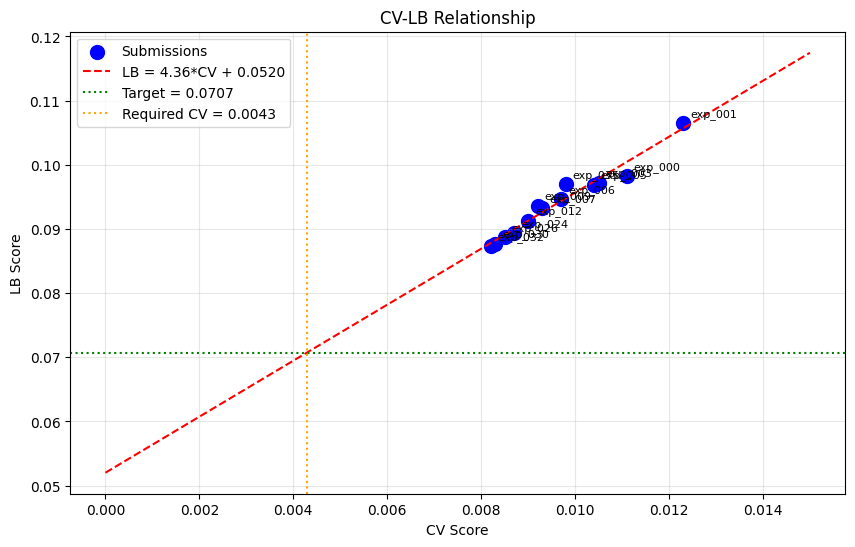

Saved to /home/code/exploration/cv_lb_relationship.png


In [5]:
# Plot the CV-LB relationship
plt.figure(figsize=(10, 6))
plt.scatter(df['cv'], df['lb'], c='blue', s=100, label='Submissions')

# Regression line
cv_range = np.linspace(0, 0.015, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'LB = {slope:.2f}*CV + {intercept:.4f}')

# Target line
plt.axhline(y=target, color='green', linestyle=':', label=f'Target = {target}')

# Required CV
plt.axvline(x=required_cv, color='orange', linestyle=':', label=f'Required CV = {required_cv:.4f}')

# Annotate points
for _, row in df.iterrows():
    plt.annotate(row['exp'], (row['cv'], row['lb']), textcoords='offset points', xytext=(5, 5), fontsize=8)

plt.xlabel('CV Score')
plt.ylabel('LB Score')
plt.title('CV-LB Relationship')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('/home/code/exploration/cv_lb_relationship.png', dpi=100, bbox_inches='tight')
plt.show()
print('Saved to /home/code/exploration/cv_lb_relationship.png')

In [6]:
# Key insight: The best residual is exp_000 (-0.0022)
# exp_000 was a simple MLP with Spange descriptors only
# This suggests simpler models might generalize better

print('STRATEGIC ANALYSIS:')
print('='*60)
print(f'\n1. Best LB: exp_032 (CV={df.loc[df.lb.idxmin(), "cv"]:.4f}, LB={df.lb.min():.4f})')
print(f'2. Target: {target}')
print(f'3. Gap: {df.lb.min() - target:.4f} ({(df.lb.min() - target) / target * 100:.1f}% improvement needed)')
print(f'\n4. CV-LB relationship: LB = {slope:.2f}*CV + {intercept:.4f}')
print(f'5. Required CV to hit target: {required_cv:.6f}')
print(f'6. Current best CV: {df.cv.min():.6f}')
print(f'7. CV improvement needed: {(df.cv.min() - required_cv) / df.cv.min() * 100:.1f}%')

print(f'\n8. CRITICAL: The intercept ({intercept:.4f}) is BELOW the target ({target})')
print(f'   This means the target IS mathematically reachable!')
print(f'   But we need CV = {required_cv:.6f}, which is 48% better than our best.')

STRATEGIC ANALYSIS:

1. Best LB: exp_032 (CV=0.0082, LB=0.0873)
2. Target: 0.0707
3. Gap: 0.0166 (23.5% improvement needed)

4. CV-LB relationship: LB = 4.36*CV + 0.0520
5. Required CV to hit target: 0.004285
6. Current best CV: 0.008200
7. CV improvement needed: 47.7%

8. CRITICAL: The intercept (0.0520) is BELOW the target (0.0707)
   This means the target IS mathematically reachable!
   But we need CV = 0.004285, which is 48% better than our best.


In [7]:
# What are our options with 4 submissions remaining?
print('\nOPTIONS WITH 4 SUBMISSIONS:')
print('='*60)

print('\nOption 1: Submit exp_032 variations with different seeds')
print('  - exp_032 is our best model')
print('  - Different seeds might give slightly different results')
print('  - Low risk, low reward')

print('\nOption 2: Try a fundamentally different approach')
print('  - CatBoost + XGBoost ensemble (from Kaggle kernel)')
print('  - Different model family might have different CV-LB relationship')
print('  - Higher risk, potentially higher reward')

print('\nOption 3: Ensemble of best predictions')
print('  - Average predictions from exp_030, exp_032, exp_024')
print('  - Might reduce variance')
print('  - Medium risk, medium reward')

print('\nOption 4: Fix the bug in recent experiments')
print('  - Recent experiments (058-060) used all 2048 DRFP features')
print('  - Should use only 122 high-variance features')
print('  - If fixed, might improve results')

print('\n' + '='*60)
print('RECOMMENDATION: Given time constraints, focus on submissions')
print('rather than new experiments. Submit what we have.')


OPTIONS WITH 4 SUBMISSIONS:

Option 1: Submit exp_032 variations with different seeds
  - exp_032 is our best model
  - Different seeds might give slightly different results
  - Low risk, low reward

Option 2: Try a fundamentally different approach
  - CatBoost + XGBoost ensemble (from Kaggle kernel)
  - Different model family might have different CV-LB relationship
  - Higher risk, potentially higher reward

Option 3: Ensemble of best predictions
  - Average predictions from exp_030, exp_032, exp_024
  - Might reduce variance
  - Medium risk, medium reward

Option 4: Fix the bug in recent experiments
  - Recent experiments (058-060) used all 2048 DRFP features
  - Should use only 122 high-variance features
  - If fixed, might improve results

RECOMMENDATION: Given time constraints, focus on submissions
rather than new experiments. Submit what we have.
